In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Muograms

In [3]:
def get_data(path):
    data_list = sorted(os.listdir(path)) # Data names list
    data = np.array([np.loadtxt(path+'/'+data, comments = '#') for data in data_list]) # Read data
    return data, data_list

In [4]:
path = '/home/kevin/Documentos/muograms3'
data, data_list = get_data(path)
print(data.shape)

(42, 100, 100)


In [5]:
cenit = np.linspace(-8, 20,100)
azimut = np.linspace(-50,50,100)

In [6]:
def plot_muograms(muograms,cenit,azimut,data_list,nrows,ncols,save=False,axis=True):
    plt.figure(figsize=(ncols*7,nrows*5))
    plt.rcParams.update({'font.size': 12})
    for i in range(len(muograms)):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(muograms[i],cmap='jet')
        plt.xticks(range(muograms.shape[2])[::20],np.round(np.unique(azimut)[::20],2))
        plt.xlabel(r'$\Theta_x$ [degree]')
        plt.yticks(range(muograms.shape[1])[::20],np.round(np.unique(cenit)[::20],2))
        plt.ylabel(r'$\Theta_y$ [degree]')
        if not axis:
            plt.axis('off')
        plt.colorbar(shrink=0.9,label='D [m]')
        #plt.title(data_list[i])
    if save:
        plt.savefig('CMmuograms.svg',format='svg')

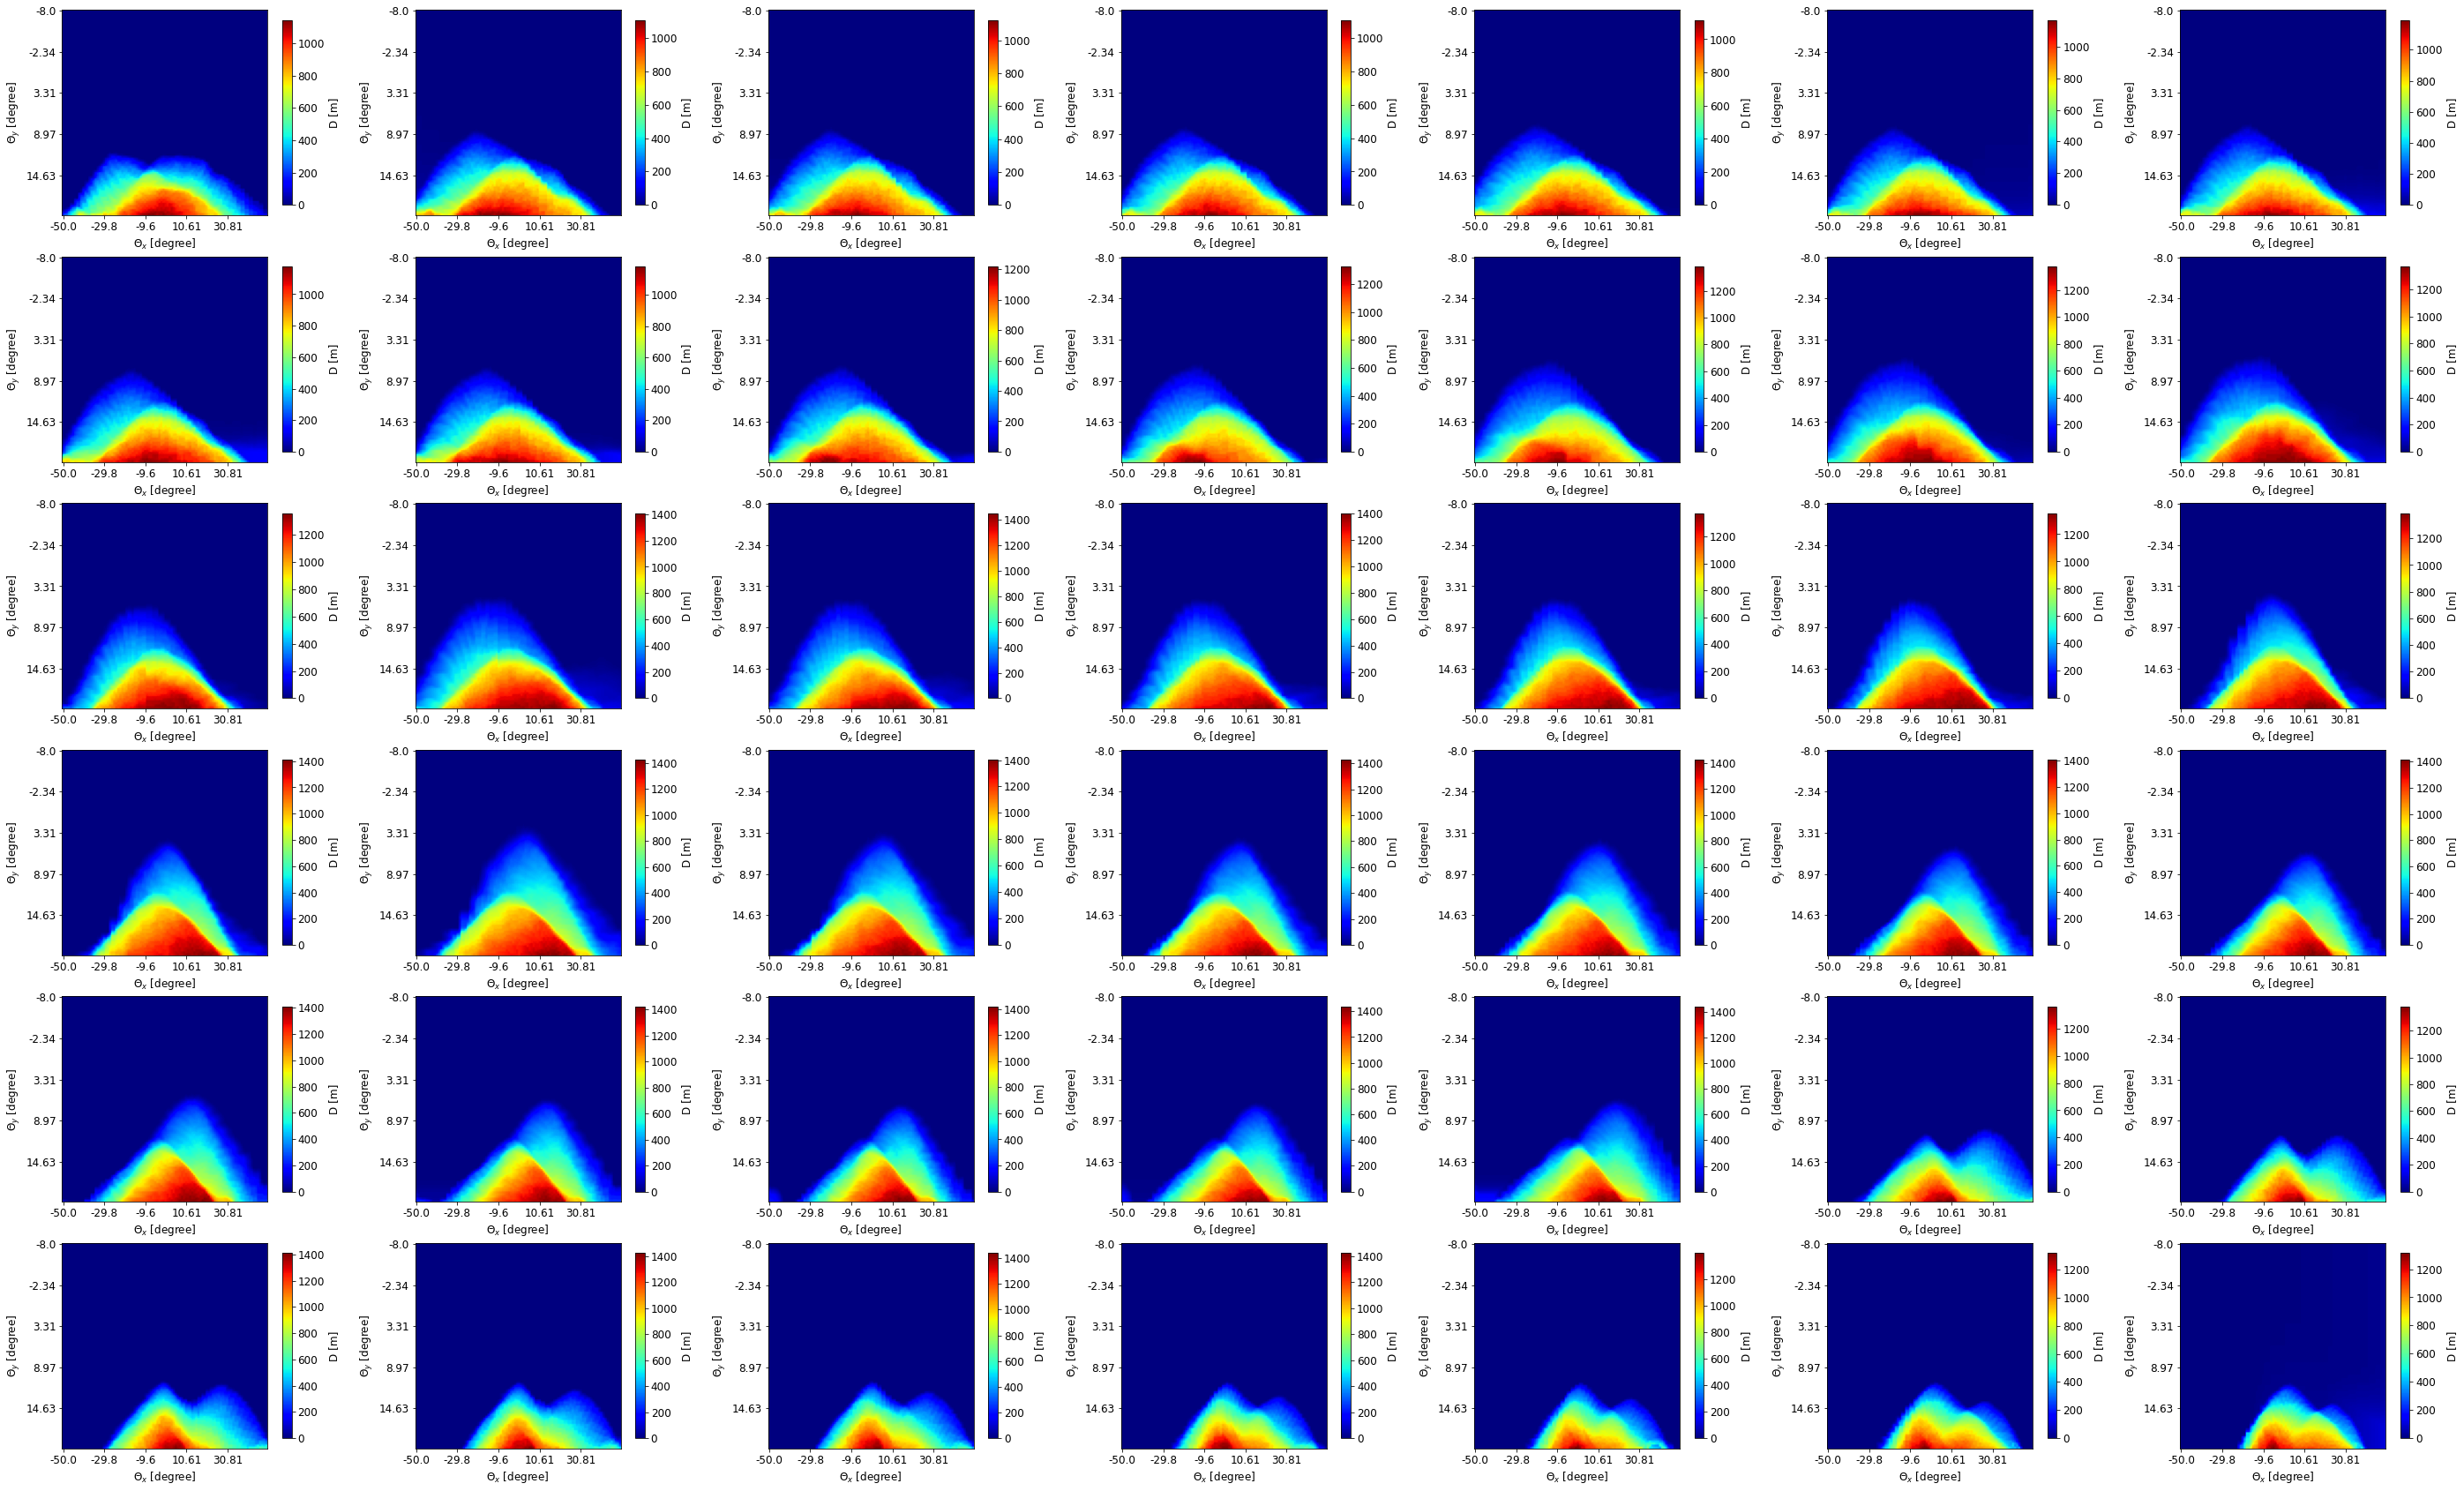

In [7]:
plot_muograms(data,cenit,azimut,data_list,6,7)

## Coordinates

In [8]:
def get_coords(path):
    return np.loadtxt(path)

In [9]:
points = get_coords('/home/kevin/coordinates5.dat')
print(points.shape)

(42, 2)


In [10]:
points2 = np.insert(points,0,np.array([[4.48666667,-75.38878788]]),axis=0)

In [11]:
def plot_detector_coords(coords,data_names,show_names=True,save=False,axis=True,heightmap=False):
    if heightmap:
        axis = False
        # Normalization to fit in heightmap
        coords[:,0] = (coords[:,0] - 4.5) / (4.47 - 4.5)*100
        coords[:,1] = (coords[:,1] - (-75.4)) / ((-75.37) - (-75.4))*100
    colors = np.ones(len(coords))+1
    colors[0] = 0 # Reference point
    colors = colors.astype('int32')
    colormap = np.array(['r','g','b'])
    plt.figure(figsize=(10,10))
    plt.scatter(coords[:,1],coords[:,0],c=colormap[colors])
    if show_names:
        for i in range(coords.shape[0]-1):
            plt.text(coords[i+1,1],coords[i+1,0],data_names[i],fontsize=8)
    plt.xlabel('long')
    plt.ylabel('lat')
    plt.title('Observation point positions')
    if axis:
        plt.axis([-75.4, -75.37, 4.47, 4.5])
    if save:
        plt.savefig('CMcoords.svg',format='svg')

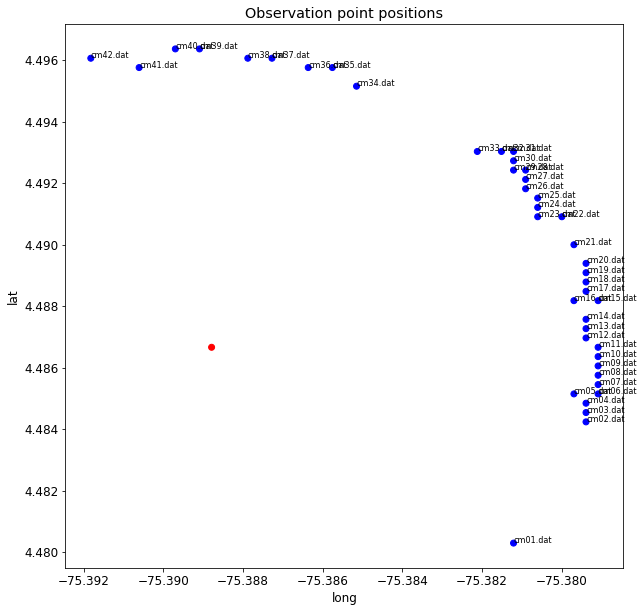

In [12]:
plot_detector_coords(points2,data_list,axis=False)

<Figure size 720x720 with 0 Axes>

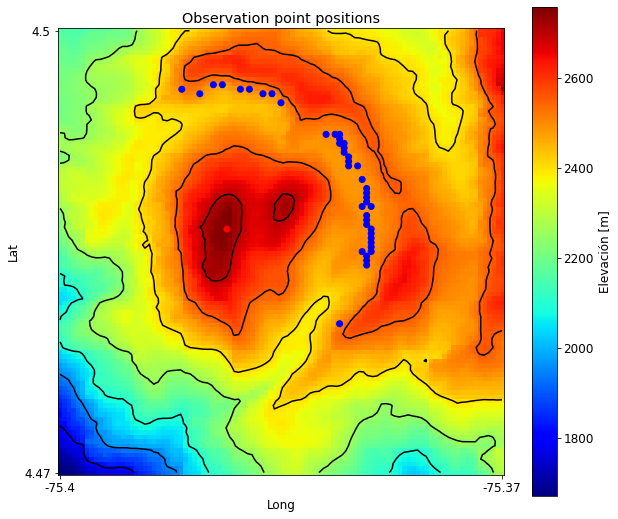

In [13]:
heightmap = np.loadtxt('/home/kevin/heightmap.dat')
#heightmap = (heightmap - np.min(heightmap)) / (np.max(heightmap) - np.min(heightmap)) # Normalization
plt.figure(figsize=(10,10))
plot_detector_coords(points2,data_list,show_names=False,heightmap=True)
plt.imshow(heightmap,cmap='jet')
plt.yticks([0,100-1],np.linspace(4.5,4.47,2))
plt.ylabel('Lat')
plt.xticks([0,100-1],np.linspace(-75.4,-75.37,2))
plt.xlabel('Long')
plt.colorbar(shrink=0.9,label='Elevación [m]')
plt.contour(heightmap,colors='k')
#plt.savefig('heightmap3.svg',format='svg')

### angles

In [14]:
def get_angles(points):
    return np.array([np.arctan2((point - points[0])[0],(point - points[0])[1])+(np.pi/2) for point in points[1:]])

In [15]:
angles = -get_angles(points2)
print(angles.shape,angles*180/np.pi)

(42,) [-130.03026637 -104.47033653 -102.72440061 -100.95411005  -99.46231199
  -98.88065014  -97.12500908  -95.35581955  -93.5763307   -91.78990876
  -90.          -88.1523917   -86.30861793  -84.4724657   -81.11934986
  -80.53768801  -79.04594874  -77.27565742  -75.52972066  -73.81081007
  -69.86371694  -64.2306979   -62.59245318  -60.94542563  -59.34936276
  -56.82152165  -55.3048805   -53.8418492   -52.76520245  -51.34022864
  -49.96977798  -48.81411388  -46.33226278  -23.19856606  -18.43492992
  -14.93140149   -9.16233746   -5.5275343     1.78990876    5.35581955
   11.30992035   17.87867878]


### How tomopy place the points

In [16]:
def create_points(R,angles):
    return np.insert(np.array([R*np.cos(angles),R*np.sin(angles)]),0,np.array([0,0]),axis=1).T

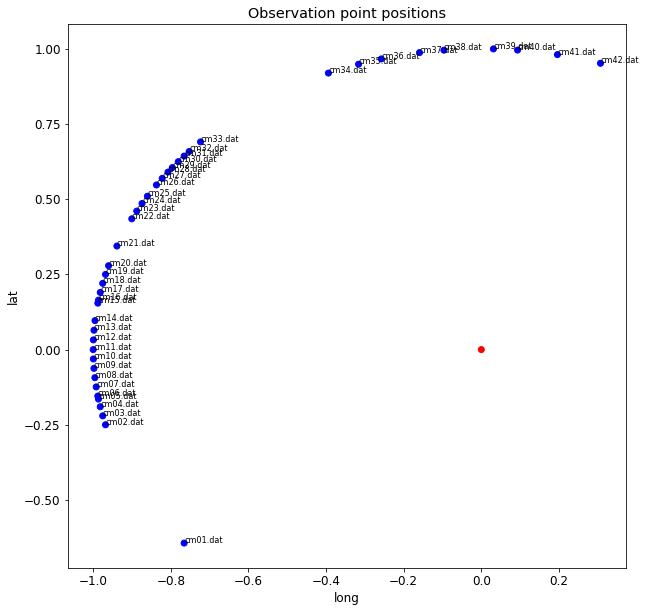

In [17]:
p = create_points(1,angles)
plot_detector_coords(p,data_list,axis=False)

## Reconstruction

In [18]:
import tomopy
rec = tomopy.recon(data,angles,algorithm='art')

In [19]:
rec[rec<0]=0 # Remove negative values (values where reconstruction doesn't happen)
rec.shape

(100, 100, 100)

In [20]:
rec2 = rec[70:,25:85,20:80] #Crop empty space in volume
rec2.shape

(30, 60, 60)

In [311]:
rec2_reshaped = rec2.reshape(rec2.shape[0], -1)
np.savetxt('rec2.dat',rec2_reshaped)

In [21]:
recZ = np.sum(rec,axis=0)
recZ_norm = (recZ - np.min(recZ)) / (np.max(recZ) - np.min(recZ)) # normalization between 0 and 1
#recZ_norm2 = 2485-(recZ*(2485/804.34186))+(recZ*(2758/804.34186))

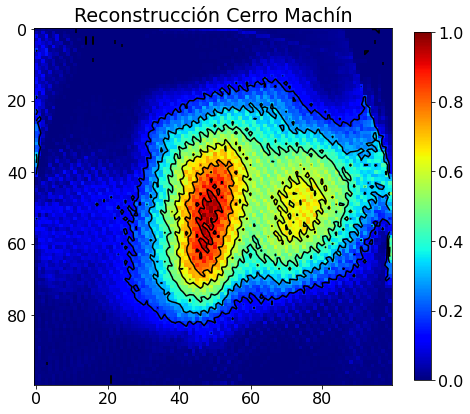

In [22]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,8))
plt.imshow(recZ_norm,cmap='jet')
plt.title('Reconstrucción Cerro Machín')
#plt.yticks([0,100-1],np.linspace(4.496,4.476,2))
#plt.ylabel('Lat')
#plt.xticks([0,100-1],np.linspace(-75.398,-75.380,2))
#plt.xlabel('Long')
plt.colorbar(shrink=0.8)
plt.contour(recZ_norm,colors='k')
#plt.savefig('recCM.svg',format='svg')

### Error estimation

Region estimation still on process

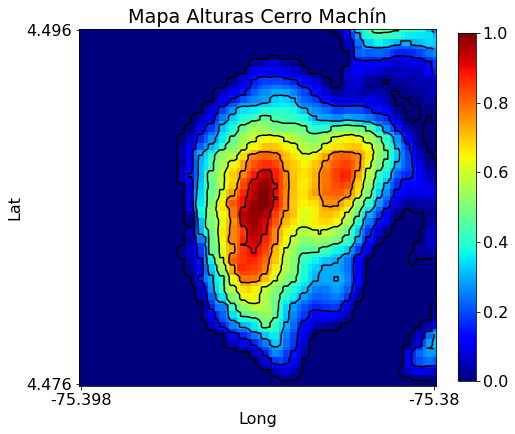

In [23]:
heightmap2 = np.loadtxt('/home/kevin/heightmap2.dat')
heightmap2[heightmap2<2485]=2485 # Remove heights lower than Po height
heightmap2 = (heightmap2 - np.min(heightmap2)) / (np.max(heightmap2) - np.min(heightmap2)) # Normalize
plt.figure(figsize=(8,8))
#plot_detector_coords(points,data_list,show_names=False,heightmap=True)
#plot_detector_coords(p,data_list,show_names=False,axis=False)
plt.imshow(heightmap2,cmap='jet')
plt.title('Mapa Alturas Cerro Machín')
plt.yticks([0,100-1],np.linspace(4.496,4.476,2))
plt.ylabel('Lat')
plt.xticks([0,100-1],np.linspace(-75.398,-75.380,2))
plt.xlabel('Long')
plt.colorbar(shrink=0.8)
plt.contour(heightmap2,colors='k')
#plt.savefig('heightmap3.svg',format='svg')

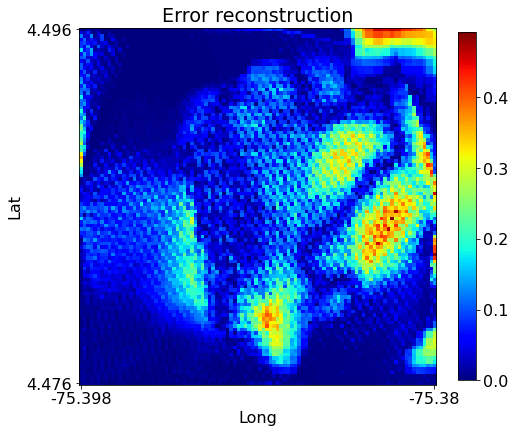

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(abs(recZ_norm-heightmap2),cmap='jet')
plt.title('Error reconstruction')
plt.yticks([0,100-1],np.linspace(4.496,4.476,2))
plt.ylabel('Lat')
plt.xticks([0,100-1],np.linspace(-75.398,-75.380,2))
plt.xlabel('Long')
plt.colorbar(shrink=0.8)
#plt.savefig('RecError.svg',format='svg')

Other views can be compared with muograms

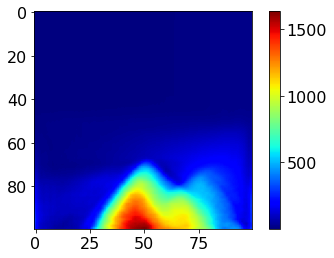

In [250]:
plt.imshow(np.sum(rec,axis=1),cmap='jet')
plt.colorbar()

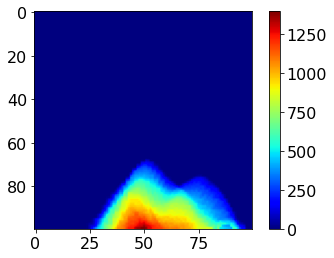

In [244]:
plt.imshow(data[-3],cmap='jet')
plt.colorbar()

Text(0.5, 1.0, 'Error')

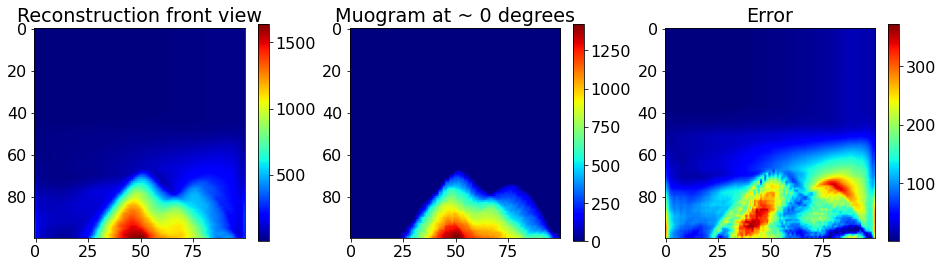

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(np.sum(rec,axis=1),cmap='jet')
plt.colorbar(shrink=0.5)
plt.title('Reconstruction front view')
plt.subplot(1,3,2)
plt.title('Muogram at ~ 0 degrees')
plt.imshow(data[-4],cmap='jet')
plt.colorbar(shrink=0.5)
plt.subplot(1,3,3)
plt.imshow(abs(data[-4]-np.sum(rec,axis=1)),cmap='jet')
plt.colorbar(shrink=0.5)
plt.title('Error')

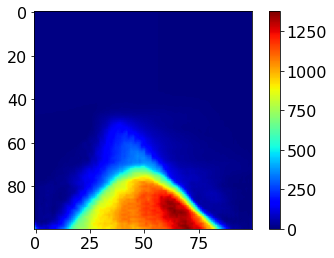

In [26]:
plt.imshow(np.sum(rec,axis=2),cmap='jet')
plt.colorbar()

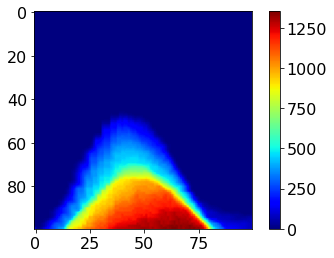

In [27]:
plt.imshow(data[19],cmap='jet')
plt.colorbar()

Text(0.5, 1.0, 'Error')

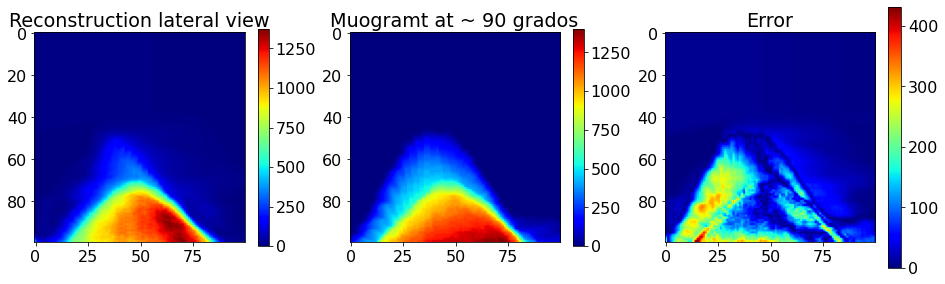

In [32]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(np.sum(rec,axis=2),cmap='jet')
plt.colorbar(shrink=0.5)
plt.title('Reconstruction lateral view')
plt.subplot(1,3,2)
plt.imshow(data[17],cmap='jet')
plt.colorbar(shrink=0.5)
plt.title('Muogramt at ~ 90 grados')
plt.subplot(1,3,3)
plt.imshow(abs(data[17]-np.sum(rec,axis=2)),cmap='jet')
plt.colorbar(shrink=0.6)
plt.title('Error')

Text(0.5, 1.0, 'Error')

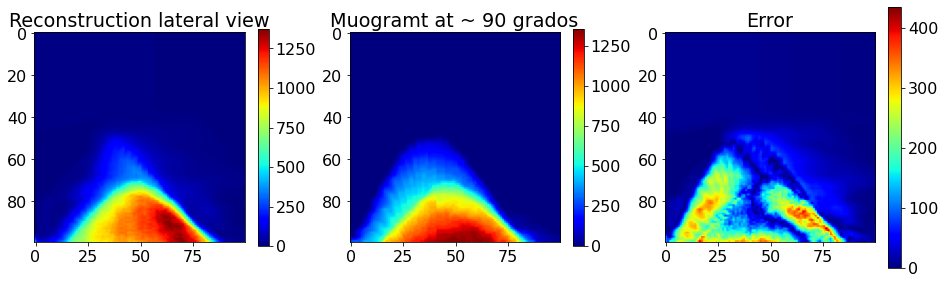

In [29]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(np.sum(rec,axis=2),cmap='jet')
plt.colorbar(shrink=0.5)
plt.title('Reconstruction lateral view')
plt.subplot(1,3,2)
plt.imshow(data[14],cmap='jet')
plt.colorbar(shrink=0.5)
plt.title('Muogramt at ~ 90 grados')
plt.subplot(1,3,3)
plt.imshow(abs(data[14]-np.sum(rec,axis=2)),cmap='jet')
plt.colorbar(shrink=0.6)
plt.title('Error')

### save gif of slices

In [39]:
for i in range(100):
    #plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,12))
    plt.imshow(rec[:,:,i],cmap='jet')
    plt.colorbar()
    # gif
    plt.savefig(f'recy/{i+1:003}.png')
    plt.close()

In [38]:
import imageio
with imageio.get_writer('recy/recy.gif', mode='I') as writer:
    for filename in sorted(os.listdir('recy')):
        image = imageio.imread('recy/'+filename)
        writer.append_data(image)

## Angle evaluation on Shepp-Logan

The idea is to estimate precision here and compare precision with volcano

### Angle variation for 42 points

In [24]:
obj = tomopy.shepp3d()

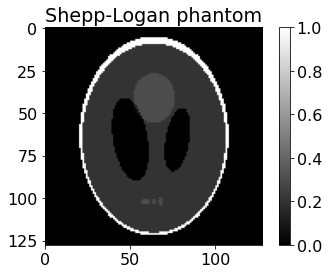

In [25]:
plt.imshow(obj[64],cmap='gray')
plt.title('Shepp-Logan phantom')
plt.colorbar()
#plt.savefig('shepp3d.svg',format='svg')

In [26]:
recs = []
for x in [np.pi,np.pi/2,np.pi/4]:
    ang = np.linspace(0,x,42)
    sim = tomopy.project(obj,ang)
    recs.append(tomopy.recon(sim,ang,algorithm='art'))
recs.append(tomopy.recon(tomopy.project(obj,angles),angles,algorithm='art'))

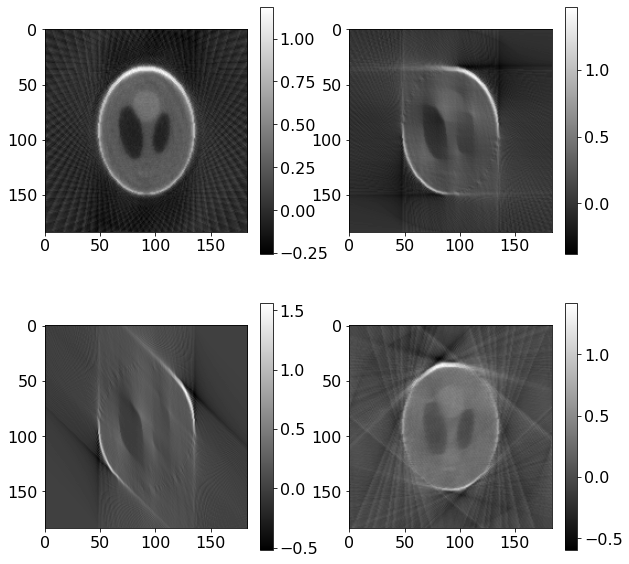

In [27]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(recs[i][64],cmap='gray')
    plt.colorbar()
#plt.savefig('shepps.svg',format='svg')